In [2]:
import numpy as np

import sys

sys.path.append('../scripts')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from elements import *

import measurement as me

In [30]:
import matplotlib.pyplot as plt
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
%matplotlib notebook

## Define optomechanical system

In [46]:
omega_c = 5e9*np.pi*2

kappa_0 = 0.3e6*np.pi*2
kappa_ex = 0.4e6*np.pi*2

kappa = kappa_0 + kappa_ex

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2

P_in = 2e-10

g_0 = 200*np.pi*2

omega_drive = omega_c - 1* omega_m


from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']
omega_c = omdir['omega_c']



a = Mode('a', omega_c)
b = Mode('b', omega_m)

a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_drive, bath_temp=10e-3)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=10e-3)

b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)

g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [a_in0,b_in0 , a_inex], [g_ab])

print ('Cooperativity C: ',g**2/kappa/gamma_m)

Cooperativity C:  87.58742521932301


## Measurement 1: Mechanical Sidebands

<IPython.core.display.Javascript object>


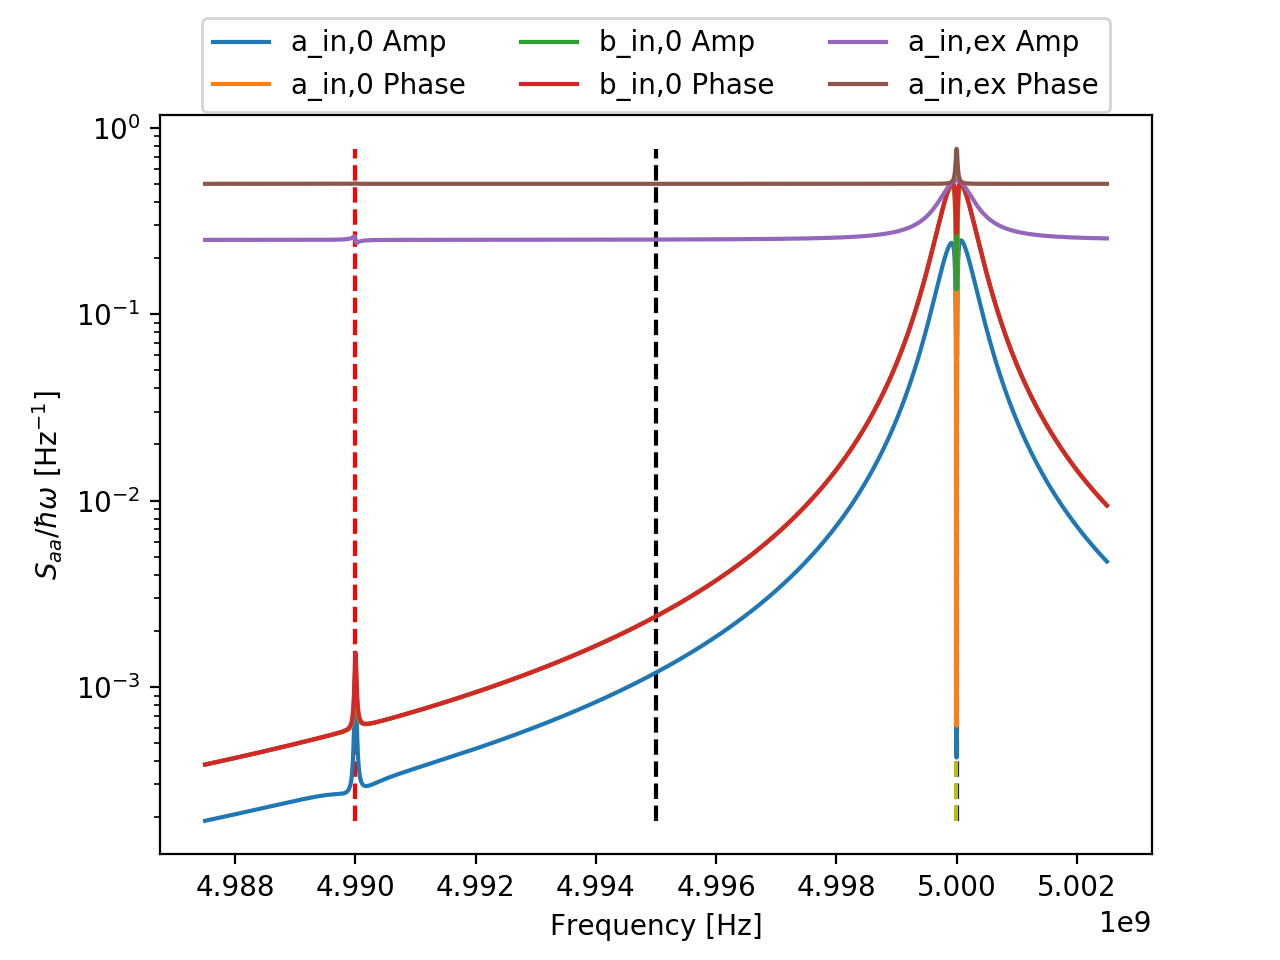

<IPython.core.display.Javascript object>


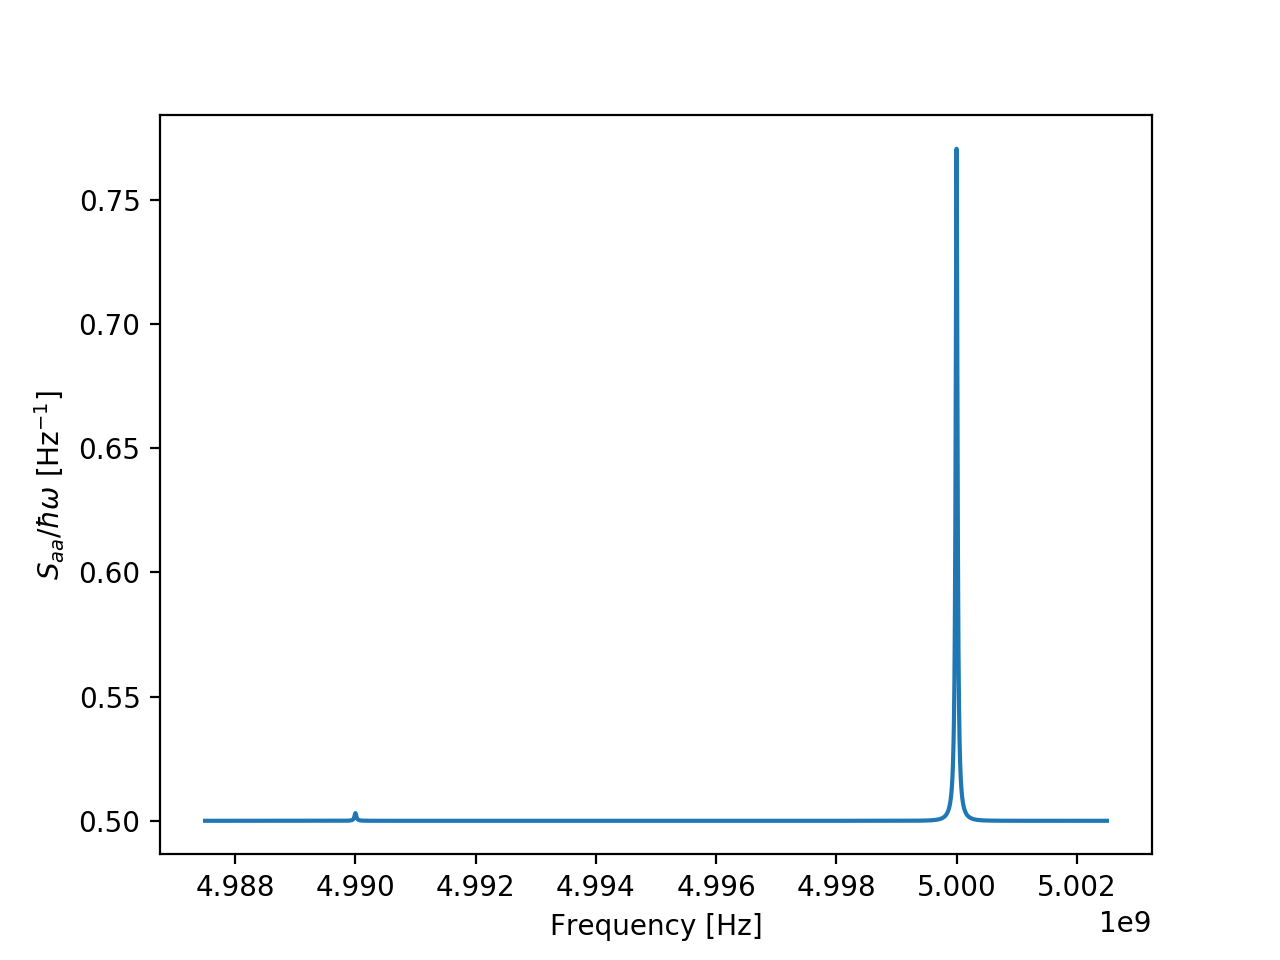

In [47]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_drive - 1.5*omega_m, omega_drive + 1.5*omega_m, 10001)

spec = me.spectrum(omegas,me.PowerMeasurement(a_outex), components=True)

plt.figure()

for i, inp in enumerate(sys_om.inputs):
    plt.semilogy(omegas/2/np.pi, spec[:,2*i], label = str(inp) + ' Amp')
    plt.semilogy(omegas/2/np.pi, spec[:,2*i + 1], label = str(inp) + ' Phase')

plt.vlines(np.array([omega_drive - omega_m, omega_drive, omega_drive + omega_m, omega_c])/2/np.pi,  np.min(spec), np.max(spec),colors=['r','black', 'b', 'y'], linestyles='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')

#plt.ylim((1e-7, None))

plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3)

plt.figure()    
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')
plt.plot(omegas/2/np.pi, spec[:,-1], label = 'Measureable Spectum');

## Measurement 2: Red sideband

<IPython.core.display.Javascript object>


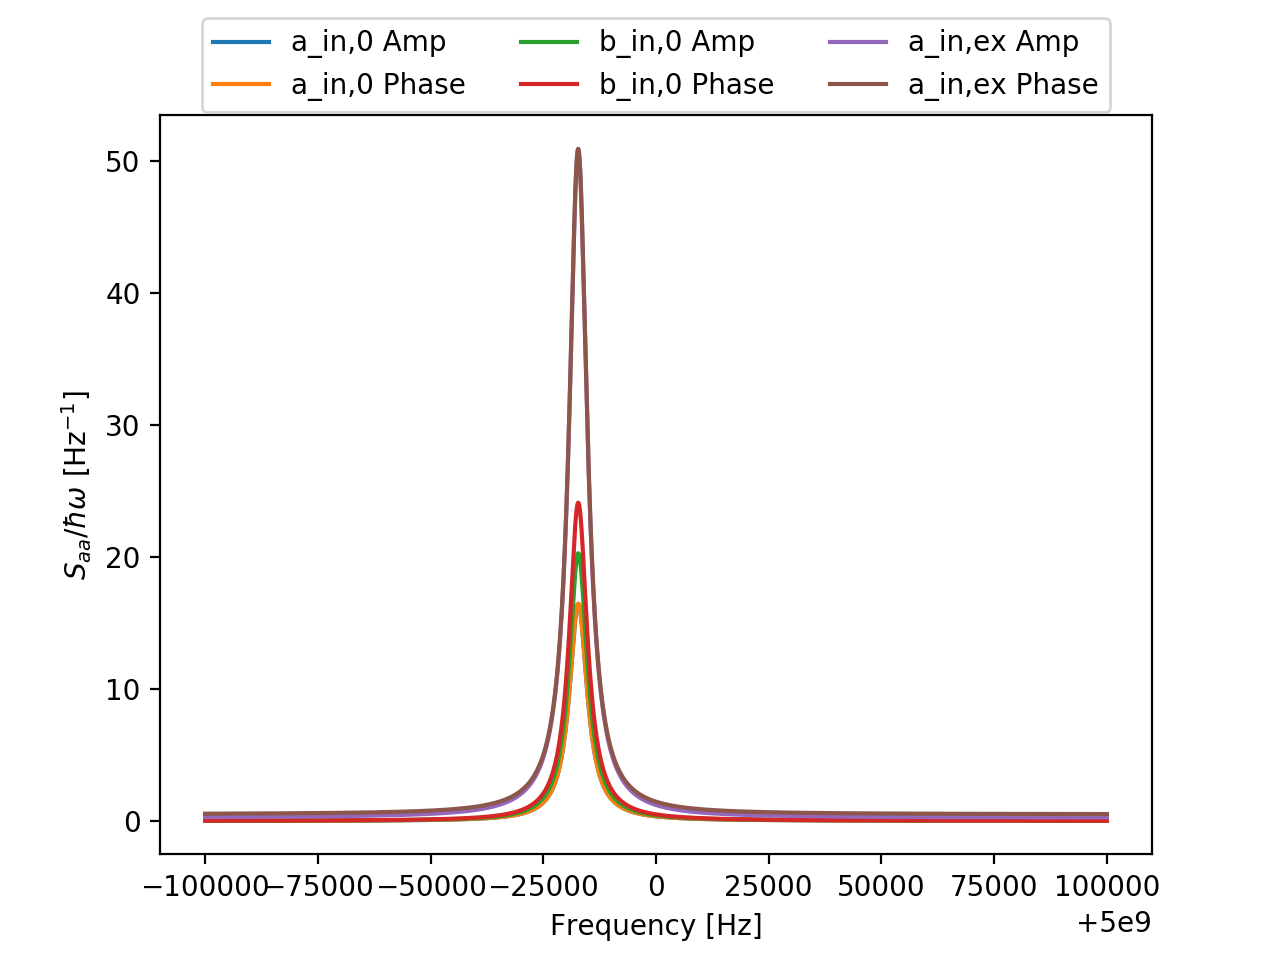

<IPython.core.display.Javascript object>


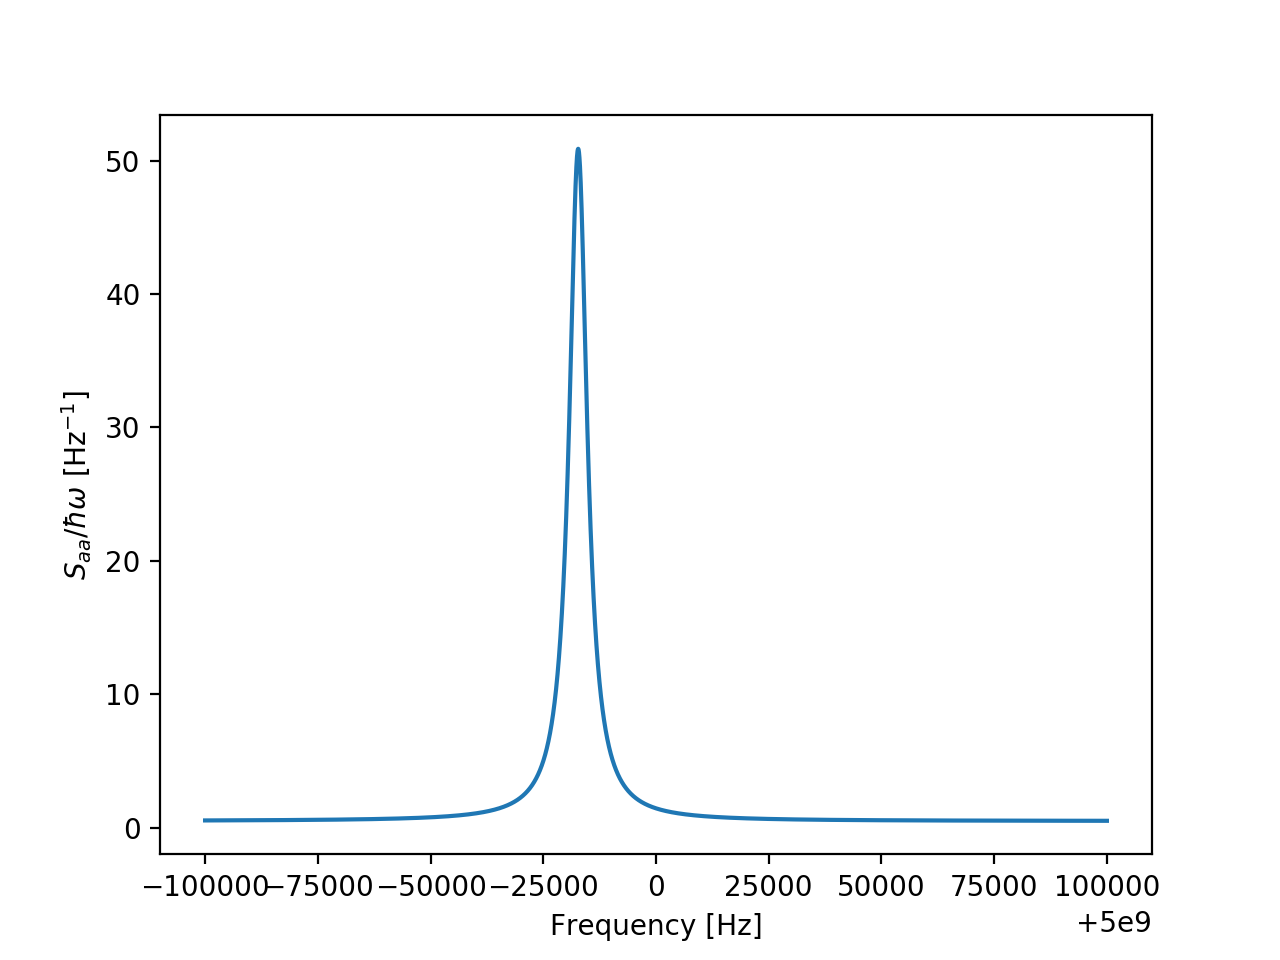

In [43]:
a_outex = Output(sys_om, a_inex)

omegas = np.linspace(omega_drive + 1.*omega_m - 1000*gamma_m, omega_drive + 1.*omega_m + 1000*gamma_m, 10001)

spec = me.spectrum(omegas,me.PowerMeasurement(a_outex), components=True)

plt.figure()

omegas = omegas - omega_m

for i, inp in enumerate(sys_om.inputs):
    plt.plot(omegas/2/np.pi , spec[:,2*i], label = str(inp) + ' Amp')
    plt.plot(omegas/2/np.pi, spec[:,2*i + 1], label = str(inp) + ' Phase')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')

plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3)

plt.figure()    
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{aa}/\hbar \omega$ [Hz$^{-1}$]')
plt.plot(omegas/2/np.pi, spec[:,-1], label = 'Measureable Spectum');